# 概要

- エンゼルの出現確率は時期によって異なるかもしれない
- 状態空間モデルを利用して出現確率の推移を予測してみる
- 前回と状態の繋がりを改良

In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from scipy import stats
import itertools

import ChocoUtils as util

import sys
import os

sys.path.append('..')
from particle_filter import ParticleFilter

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

c_list = sns.color_palette().as_hex()
color_num = len(c_list)

In [2]:
%load_ext autoreload
%autoreload 2

# データの取得

フィルタ条件

- 賞味期限月の記録のないレコードを除外 : 集計を賞味期限月で行うため
- 金のエンゼル２倍キャンペーン(campaign=1)を除外 : 問題の簡単化のため
- パイナップル味(taste=10)を除外 : 国内向け商品ではなく、エンゼルキャンペーンの対象外のため

In [3]:
db_file = '../../data/choco-ball.db'
f_str = 'best_before is not null AND campaign != 1 AND taste != 10'
df_p = util.get_data(db_file=db_file, filter_str=f_str)

select_col = [
    'measure_date', 
    'best_before', 
    'taste', 
    'angel', 
    'campaign', 
]
df = df_p[select_col]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE best_before is not null AND campaign != 1 AND taste != 10;
Shape of MeasurementData(record_num, n_columns) : (725, 14)


## データの前処理: 銀のエンゼルが出たか否か

angelのフラグを1は1、それ以外は0とする

In [4]:
df = df.assign(
    silver=[1 if agl==1 else 0 for agl in df.angel]
)

In [5]:
df.groupby('silver').count()

,measure_date,best_before,taste,angel,campaign
silver,,,,,
0,693,693,693,693,693
1,32,32,32,32,32


## データの前処理: 賞味期限月の処理

- 文字列になっているので、dateオブジェクトに変換
- 月表示に変更
- index(DatetimeIndexに指定)

In [6]:
bb = pd.to_datetime(df.best_before)
df.best_before = bb
df['bb_ym'] = [x.strftime('%Y/%m') for x in df.best_before]
df.set_index('best_before', inplace=True)

# 生のデータの確認

In [7]:
N = df.resample('M').count()[['silver']]
N.columns = ['cnt']
angel = df.resample('M').sum()[['silver']]
#angel.columns = ['angel']
df_sum_angel = pd.concat([N, angel], axis=1)
df_sum_angel = df_sum_angel.assign(
    rate=df_sum_angel.silver/df_sum_angel.cnt
)

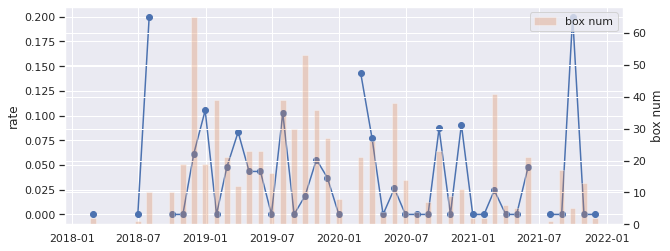

In [8]:
fig = plt.Figure(figsize=(10, 4))
ax = fig.subplots(1,1)
ax2 = ax.twinx()

ax.plot(df_sum_angel.rate, 'o-', color=c_list[0], label='rate')
ax2.bar(x=df_sum_angel.index, height=df_sum_angel.cnt, width=15, color=c_list[1], alpha=0.3, label='box num')
ax.set_ylabel('rate')
ax2.set_ylabel('box num')
ax2.legend()
display(fig)

# エンゼル出現確率の推論

In [9]:
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-1. * z))
    return s

In [10]:
def obs_model(y_t, x_t, params=None):
    """観測モデル
    観測モデルは二項分布
    
    Args:
        y_t [np.array([int, int])]: 観測値, [購入数, エンゼル個数]
        theta_t [float]: 確率
        params [dict] : パラメータ. 
    Return: 
        w [float]: Probably Mass
    """
    n_t = y_t[0]
    z = y_t[1]
    theta_t = sigmoid(x_t)
    w = stats.binom(n=n_t, p=theta_t).pmf(z)
    return w#[0]

In [11]:
def system_model(x_pre, params):
    """システムモデル
    確率は変動しないと仮定
    
    Args: 
        x_pre [numpy.array] : 前の状態のサンプル(パーティクル)
        params [dict] : 
            'scale' : 正規乱数の標準偏差
    Returns: 
    """
    scale = params['scale']
    xt = stats.norm(loc=x_pre, scale=scale).rvs()
    return xt

In [12]:
def initial_particles(loc=0.0, scale=1.0, n=1000):
    """パーティクルの初期分布
    一様分布
    
    Argument:
        loc [float]: 一様乱数の範囲（開始点）
        scale [float]: 一様乱数の範囲(幅)
        n [int]: パーティクル数
    Return:
        [np.array(N, D)]: パーティクル集合
                    N: パーティクル数
                    D: 状態次元
    """
    #X = stats.uniform(loc=loc, scale=scale).rvs(size=n)
    X = stats.norm(loc=loc, scale=scale).rvs(size=n)
    return X[:,np.newaxis]

## 初期分布の生成

In [13]:
n_particles = 1000

<AxesSubplot:ylabel='Count'>

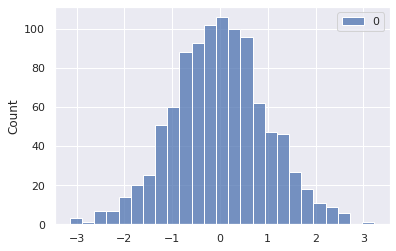

In [14]:
X_ini = initial_particles(n=n_particles, loc=0., scale=1)
sns.histplot(X_ini)

<AxesSubplot:ylabel='Count'>

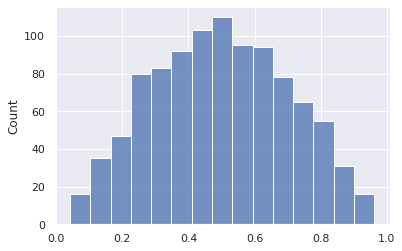

In [15]:
theta_ini = [sigmoid(x[0]) for x in X_ini]
sns.histplot(theta_ini)

## パーティクルフィルタによる状態推定

In [16]:
params = {
    'scale':0.5, 
}

pf = ParticleFilter(
    init_particles=X_ini, 
    system_model=system_model, 
    obs_model=obs_model, 
    params=params, 
)

n_particles : 1000


In [17]:
obs = np.array([df_sum_angel.cnt, df_sum_angel.silver]).T

In [18]:
pf.calc(obs)

0it [00:00, ?it/s]

particle filtering


46it [01:12,  1.57s/it]


In [19]:
particles = pf.hist_particles
particles.shape

(46, 1000)

In [20]:
particle_thetas = sigmoid(particles)

### 推論結果の確認

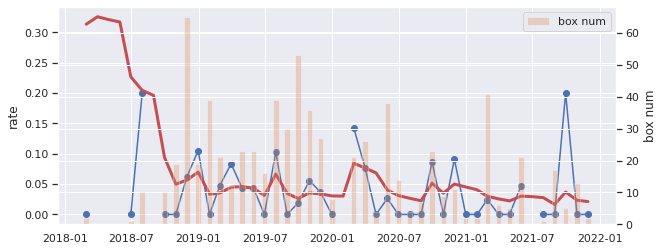

In [21]:
fig = plt.Figure(figsize=(10, 4))
ax = fig.subplots(1,1)
ax2 = ax.twinx()

ax.plot(df_sum_angel.rate, 'o-', color=c_list[0], label='rate')
ax2.bar(x=df_sum_angel.index, height=df_sum_angel.cnt, width=15, color=c_list[1], alpha=0.3, label='box num')
ax.set_ylabel('rate')
ax2.set_ylabel('box num')
ax2.legend()

ax.plot(df_sum_angel.index, np.median(particle_thetas, axis=1), color=c_list[3], lw=3, label='estimated')

display(fig)

In [22]:
def plot_particles(obs, particles, true_state=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(1, 1, 1)
    ts = [t for t in range(len(obs))]
    ax.plot(ts, obs, c=c_list[0], label='observ')
    if true_state is not None:
        ax.plot(ts, true_state, c=c_list[1], label='true state')
    
    n_particles = particles.shape[1]
    particles_flat = list(itertools.chain.from_iterable(particles))
    particles_t = [np.repeat(t, n_particles) for t in ts]
    particles_t = list(itertools.chain.from_iterable(particles_t))
    particles_mean = [np.median(ps) for ps in particles]
    ax.plot(ts, particles_mean, lw=3, c=c_list[3], label='particle_mean')
    ax.scatter(particles_t, particles_flat, c=c_list[2], alpha=0.01)
    ax.legend()

(0.0, 0.3)

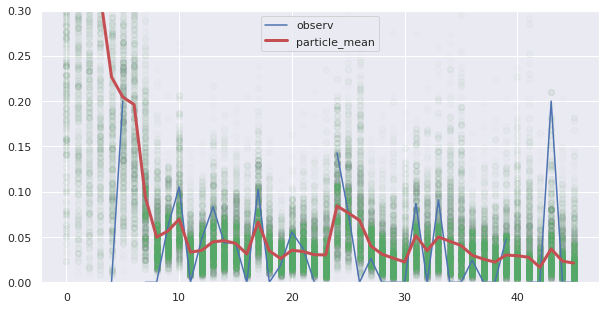

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

plot_particles(df_sum_angel.rate, particle_thetas, ax=ax)
ax.set_ylim(0, 0.3)

In [24]:
particle_thetas[-1].mean()

0.030265788891024433

# 前回との比較

In [25]:
particles_v1 = np.load("choco_sequence_v1.npy")
particles_v1.shape

(46, 1000)

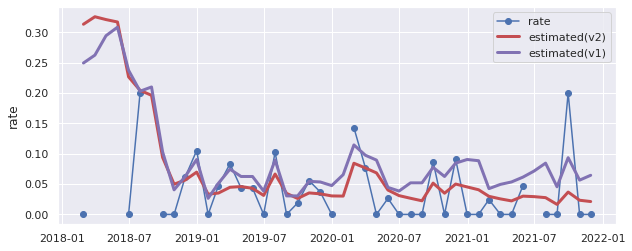

In [29]:
fig = plt.Figure(figsize=(10, 4))
ax = fig.subplots(1,1)

ax.plot(df_sum_angel.rate, 'o-', color=c_list[0], label='rate')
ax.set_ylabel('rate')

ax.plot(df_sum_angel.index, np.median(particle_thetas, axis=1), color=c_list[3], lw=3, label='estimated(v2)')
ax.plot(df_sum_angel.index, np.median(particles_v1, axis=1), color=c_list[4], lw=3, label='estimated(v1)')

ax.legend()
display(fig)

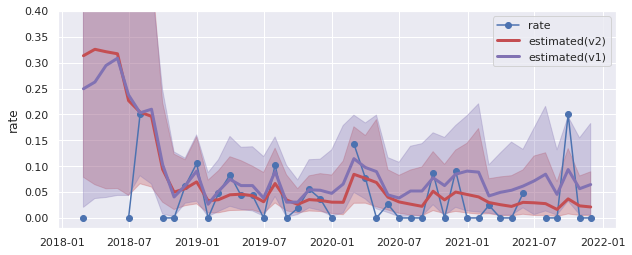

In [42]:
fig = plt.Figure(figsize=(10, 4))
ax = fig.subplots(1,1)

ax.plot(df_sum_angel.rate, 'o-', color=c_list[0], label='rate')
ax.set_ylabel('rate')

ax.fill_between(
    df_sum_angel.index, 
    np.percentile(particle_thetas, 5, axis=1), 
    np.percentile(particle_thetas, 95, axis=1), 
    color=c_list[3], alpha=0.3
)
ax.plot(df_sum_angel.index, np.median(particle_thetas, axis=1), color=c_list[3], lw=3, label='estimated(v2)')

ax.fill_between(
    df_sum_angel.index, 
    np.percentile(particles_v1, 5, axis=1), 
    np.percentile(particles_v1, 95, axis=1), 
    color=c_list[4], alpha=0.3
)
ax.plot(df_sum_angel.index, np.median(particles_v1, axis=1), color=c_list[4], lw=3, label='estimated(v1)')

ax.set_ylim(-0.02, 0.4)
ax.legend()
display(fig)